In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import random

%matplotlib inline

In [3]:
root_path = Path('/home/zhouzr/project/competition/Kaggle-ASHRAE/ashrae/')
train = pd.read_pickle(root_path / 'train.pkl')
test  = pd.read_pickle(root_path / 'test.pkl')
weather_train = pd.read_pickle(root_path / 'weather_train.pkl')
weather_test = pd.read_pickle(root_path / 'weather_test.pkl')
meta = pd.read_pickle(root_path / 'building_metadata.pkl')
sample_submission = pd.read_pickle(root_path / 'sample_submission.pkl')

In [19]:
meter_name = {0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}

In [86]:
train = train.merge(meta, on='building_id', how='left')

## Target

In [89]:
site_usage = train.groupby(['site_id', train.timestamp, 'meter']).meter_reading.sum().reset_index()

In [99]:
train.groupby('site_id')['building_id'].apply(lambda x: x.unique().size)

site_id
0     105
1      51
2     135
3     274
4      91
5      89
6      44
7      15
8      70
9     124
10     30
11      5
12     36
13    154
14    102
15    124
Name: building_id, dtype: int64

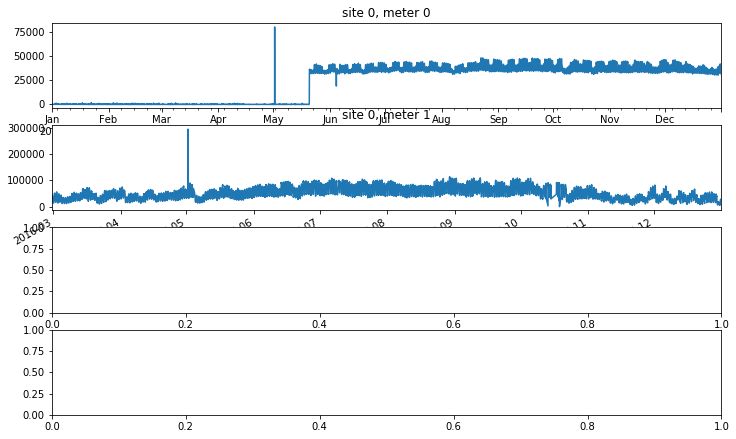

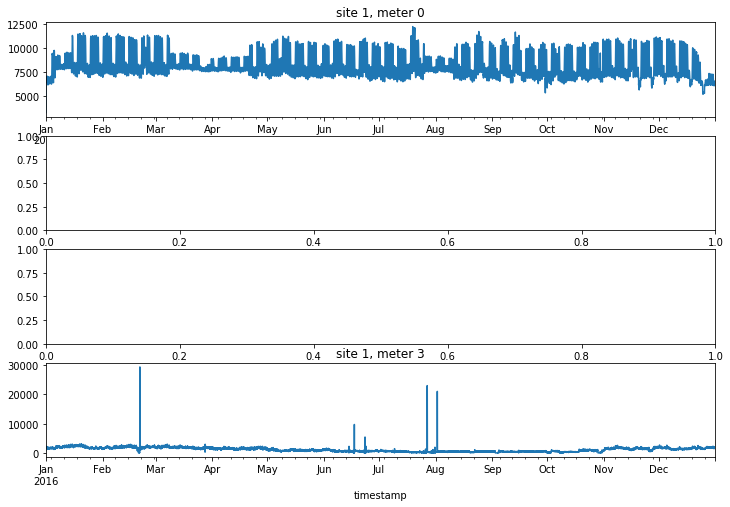

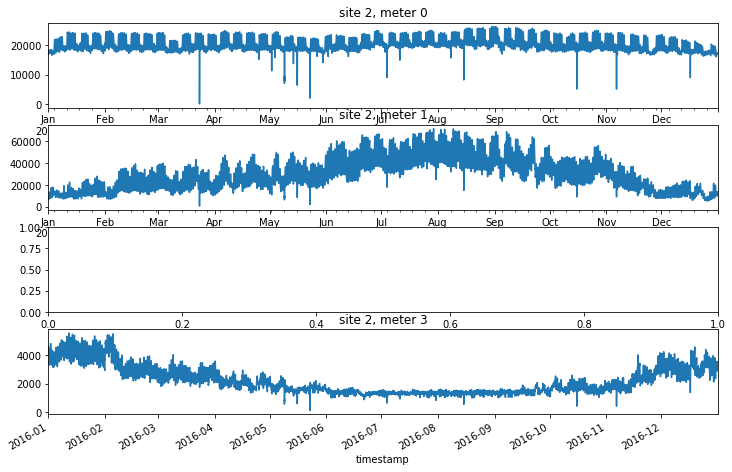

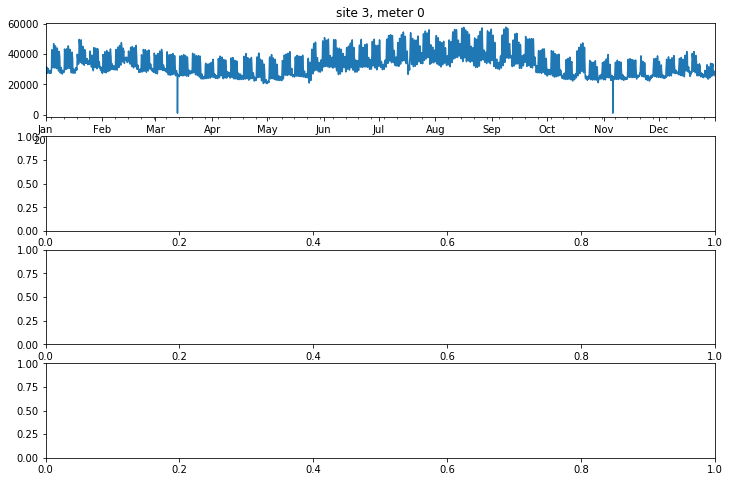

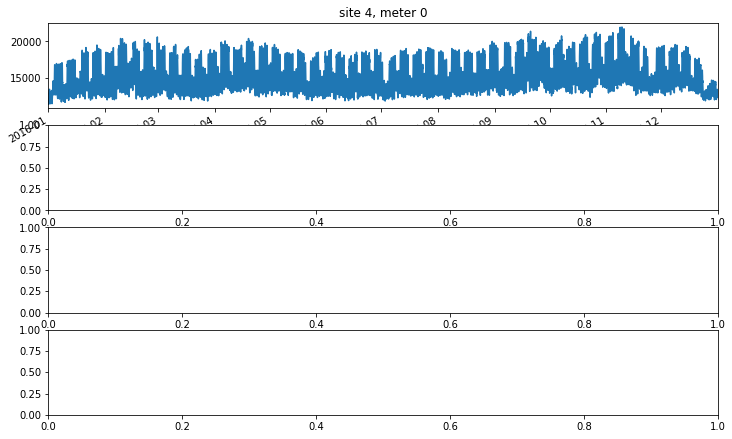

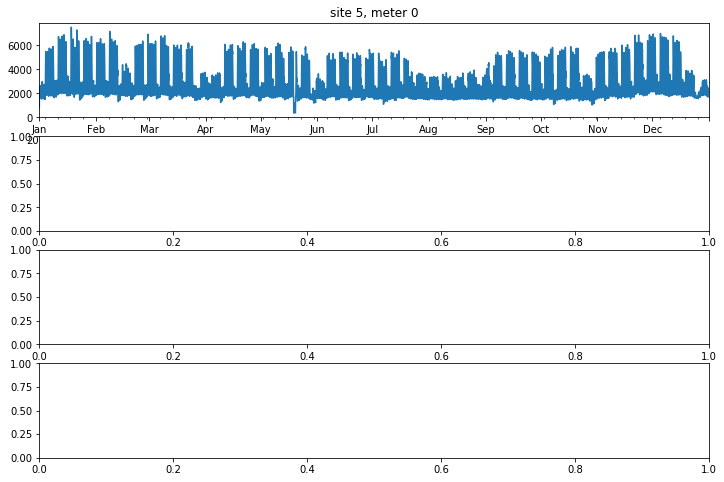

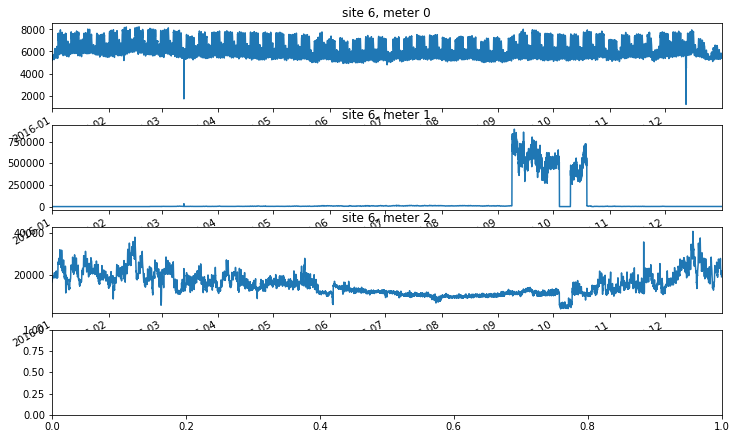

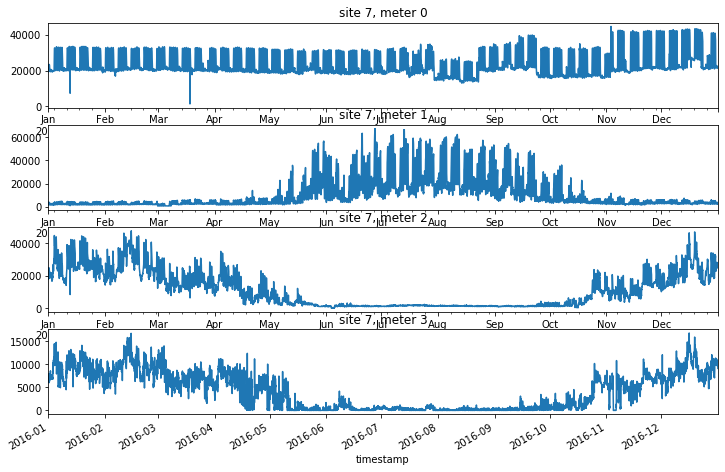

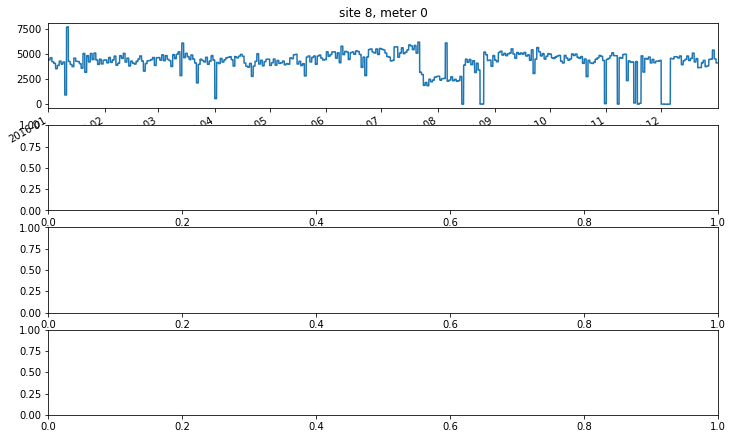

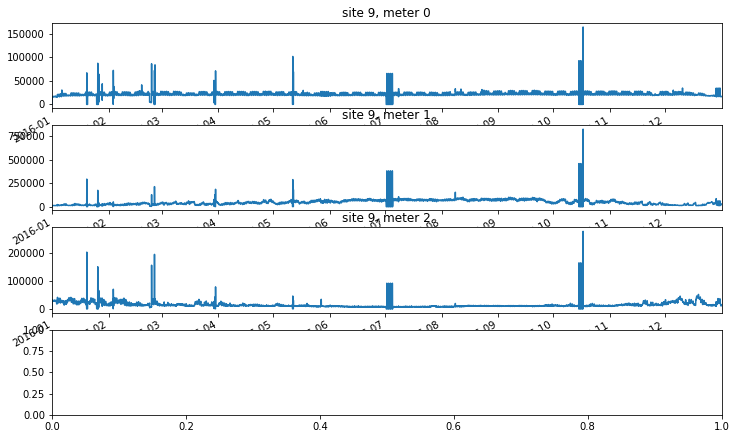

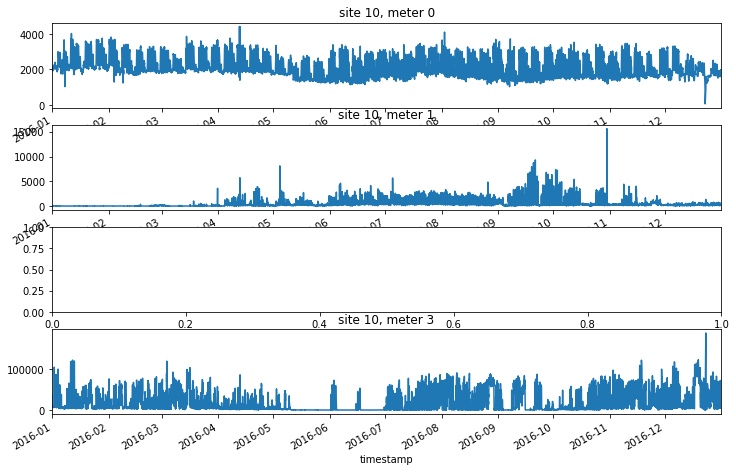

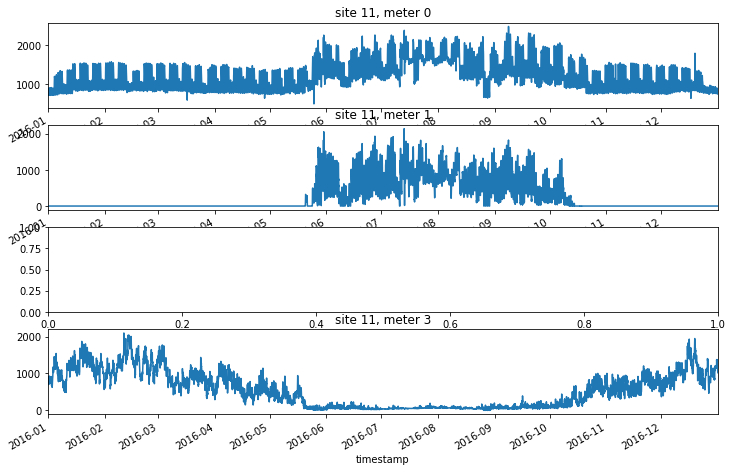

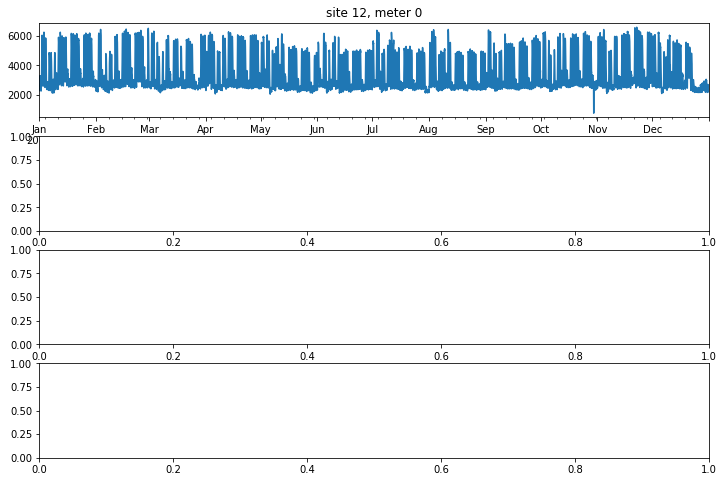

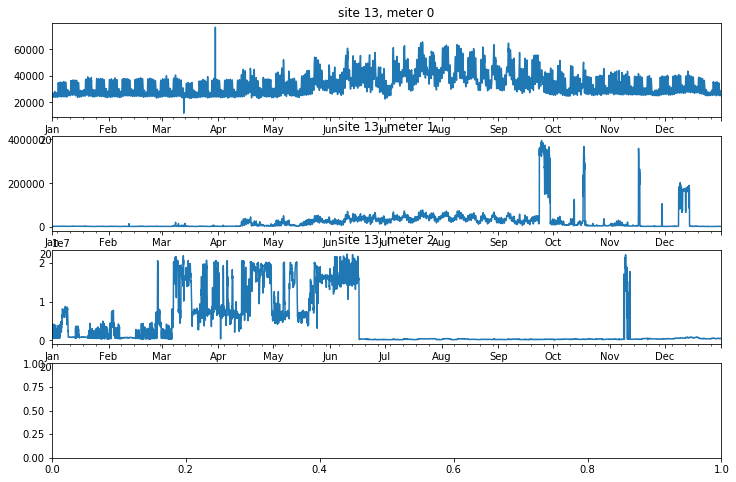

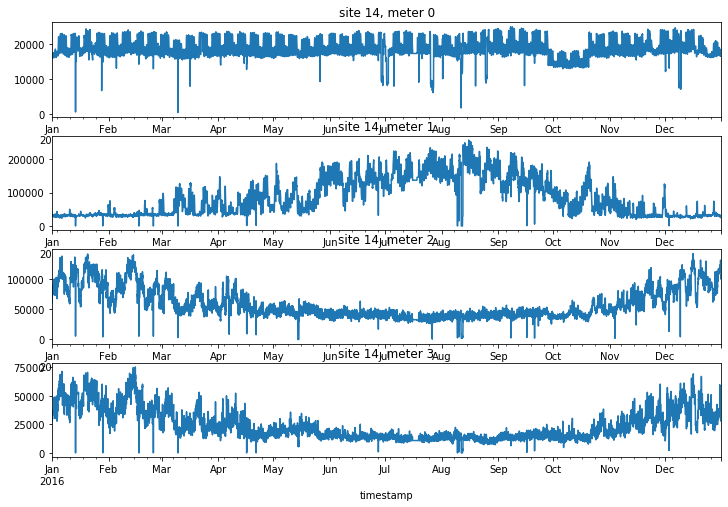

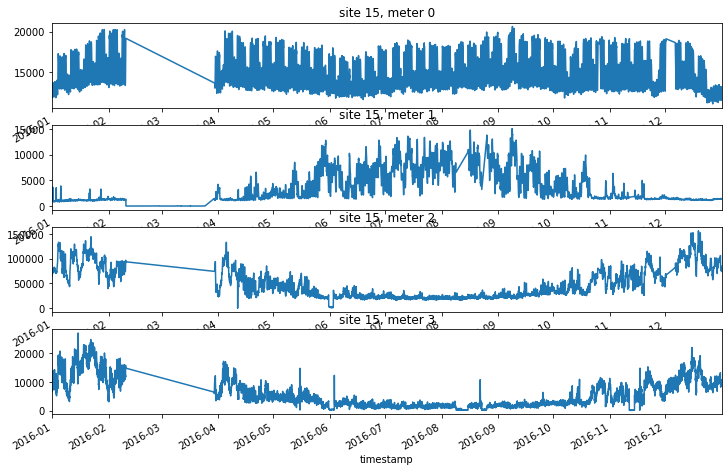

In [102]:
for site in site_usage.site_id.unique():
    f, axes = plt.subplots(4, 1, figsize=(12, 8))
    c = (site_usage.site_id == site)
    for meter in [0, 1, 2, 3]:
        try:
            site_usage[c & (site_usage.meter == meter)].set_index('timestamp').meter_reading.plot(ax=axes[meter])
            axes[meter].set_title(f'site {site}, meter {meter}')
        except:
            pass

In [30]:
zero_count = train[train.meter_reading == 0].groupby(['building_id', 'meter'])['timestamp'].count().rename('zero_count').reset_index()

In [37]:
zero_count['zero_count'].rank()

0       1311.0
1       1278.0
2       1312.5
3       1375.0
4       1304.0
         ...  
1566     431.0
1567     453.0
1568    1397.0
1569     114.0
1570    1412.0
Name: zero_count, Length: 1571, dtype: float64

In [41]:
zero_count

,building_id,meter,zero_count
0,0,0,3373
1,1,0,3237
2,2,0,3374
3,3,0,3378
4,4,0,3352
...,...,...,...
1566,1437,2,56
1567,1438,2,61
1568,1442,2,3507
1569,1444,0,2


In [43]:
zero_count.groupby('meter').apply(lambda group: group.sort_values('zero_count', ascending=False).head(5))

building_id  meter  zero_count
meter                                     
0     1165         1221      0        7404
      1478         1345      0        6506
      576           802      0        5645
      605           857      0        5561
      804           954      0        5343
1     948          1018      1        8772
      953          1022      1        8766
      942          1013      1        7643
      280           252      1        7504
      1012         1093      1        7458
2     1252         1250      2        8536
      515           762      2        7270
      512           758      2        7185
      1143         1207      2        6824
      1195         1232      2        6632
3     327           287      3        8740
      316           279      3        8732
      145           163      3        8152
      300           263      3        8081
      929          1003      3        7974

In [64]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000
20216096,1445,0,2016-12-31 23:00:00,4.825000
20216097,1446,0,2016-12-31 23:00:00,0.000000
20216098,1447,0,2016-12-31 23:00:00,159.574997


In [66]:
zero_count = train.groupby(['building_id', train.timestamp.dt.date]).apply(lambda x: (x.meter_reading == 0).sum() / x.shape[0])

In [72]:
zero_count = zero_count.rename('zero_rate').reset_index().pivot_table(index='building_id', columns='timestamp', values='zero_rate')

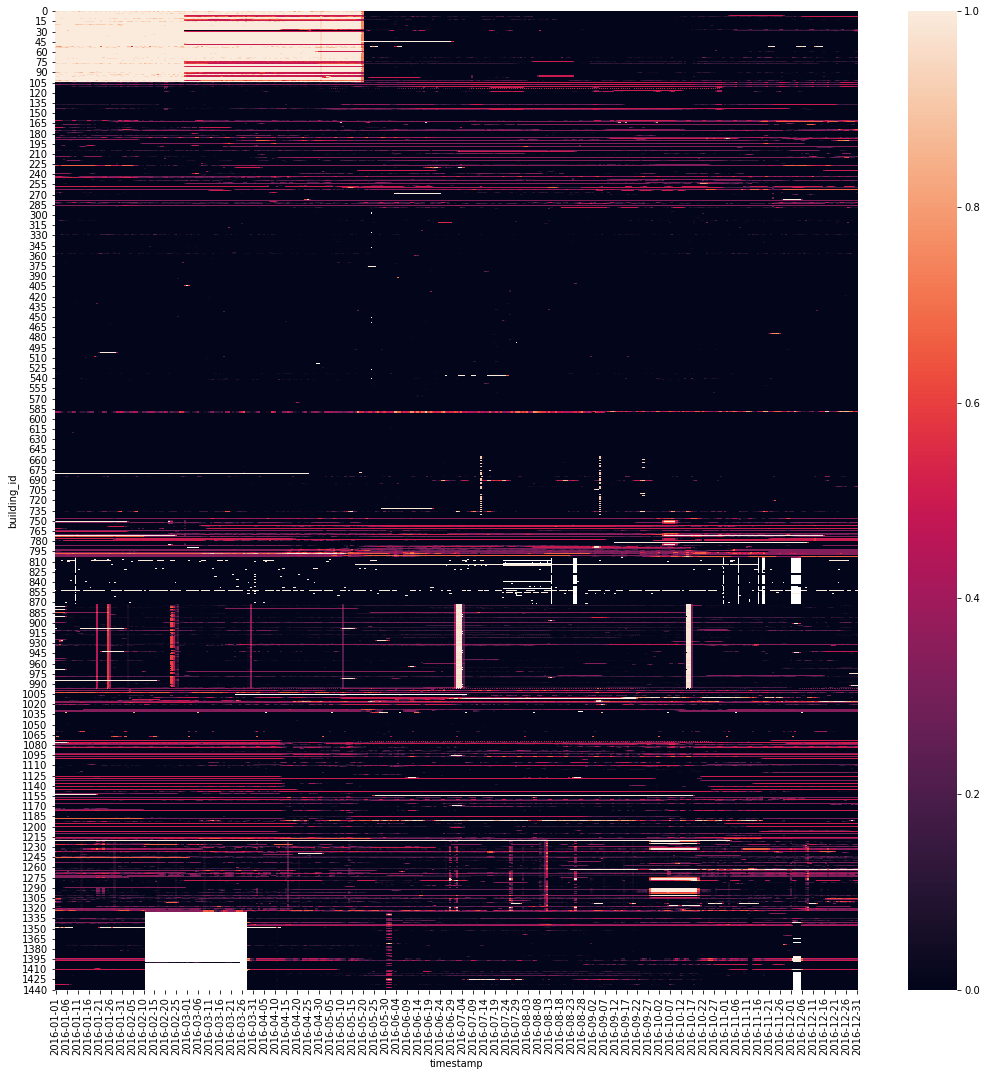

In [75]:
plt.figure(figsize=(18, 18))
sns.heatmap(zero_count)

In [50]:
def plot_building(building_id, meter=None):
    f = plt.figure(figsize=(12, 6))
    for meter_i, group in train[train.building_id == building_id].groupby('meter'):
        if (meter is None) or (meter == meter_i):
            group.set_index('timestamp')['meter_reading'].plot(label=meter_i)
    plt.legend()

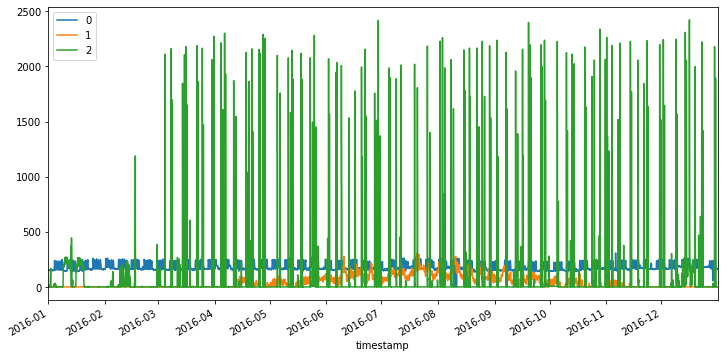

In [60]:
plot_building(1207)

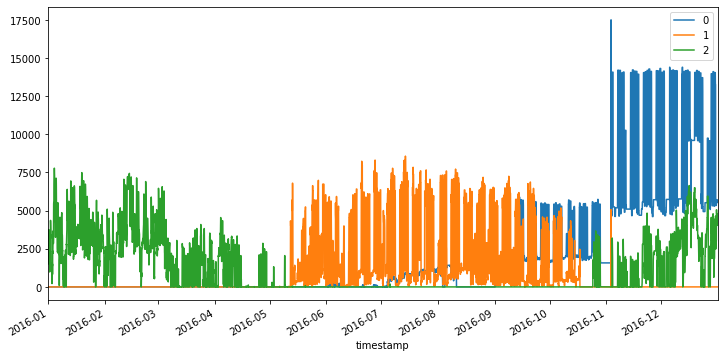

In [17]:
plot_building(799)

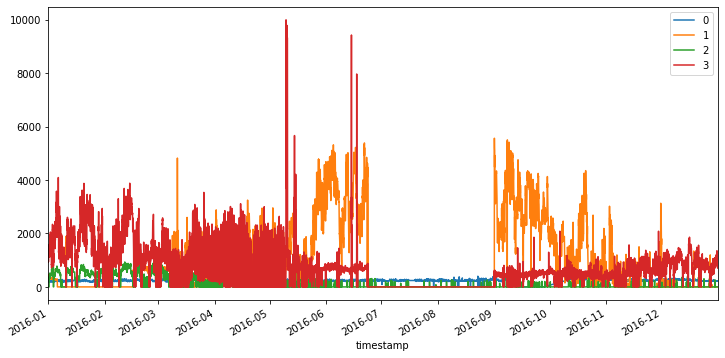

In [20]:
plot_building(1232)

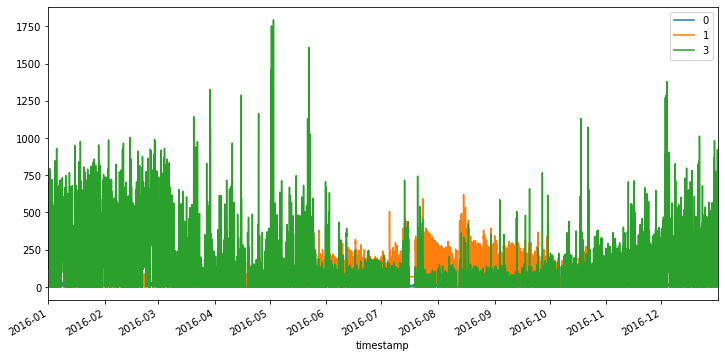

In [22]:
plot_building(1270)

In [23]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000
20216096,1445,0,2016-12-31 23:00:00,4.825000
20216097,1446,0,2016-12-31 23:00:00,0.000000
20216098,1447,0,2016-12-31 23:00:00,159.574997
